# A3: Make Your Own Machine Translation Language

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np

In [4]:
# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Dataset Selection
For this assignment, we will use the sharad461/ne-en-parallel-208k dataset from Hugging Face, as it is a standard, reputable source for English-Nepali parallel sentences. We will load a subset for speed and demonstrate the preparation process.

Dataset Attribution: * Source: sharad461/ne-en-parallel-208k

Description: Contains ~208,000 parallel sentence pairs.

In [5]:
from datasets import load_dataset

# Load the dataset (using a small subset for this assignment to keep it simple)
full_dataset = load_dataset("sharad461/ne-en-parallel-208k", split='train')

# Select 10,000 examples for manageable training on standard machines
data_subset = full_dataset.select(range(10000))

print(f"Sample English: {data_subset[0]['en']}")
print(f"Sample Nepali: {data_subset[0]['ne']}")

c:\NLP_notebook\A3\nlp_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sample English: It happened after the death of Saul, when David was returned from the slaughter of the Amalekites, and David had stayed two days in Ziklag;
Sample Nepali: दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शाऊलको मृत्यु भएको केही दिन पछिको कुरा हो। दाऊद त्यहाँ दुइ दिन बसे।


## Preprocessing Logic
Before we can build the model, we must segment the text.

English: Standard whitespace/punctuation tokenization.

Nepali: Being a Devanagari script language, it is highly inflectional. In a professional setting, subword tokenizers (like WordPiece) are used. We will use a character-based or word-based approach to avoid external library dependencies like nepali-tokenizers, manually building our vocabulary from the data itself.

### Vocabulary Building & Numericalization
We define a Vocab class that manages three core dictionaries:

word2idx: Maps each word to a unique integer.

idx2word: Maps each integer back to its original word (used during inference).

word2count: Keeps track of word frequencies, which is helpful for filtering rare words.

## The Vocab Class

We include four special **reserved tokens** required for Seq2Seq models:

- **`<pad>`**: Used to pad sentences so that all sequences in a batch have the same length.
- **`<sos>`**: Marks the *start of a sentence*.
- **`<eos>`**: Marks the *end of a sentence*.
- **`<unk>`**: Represents *unknown words* that do not appear in the training vocabulary.


In [6]:
class Vocab:
    def __init__(self):
        # Initialize with special tokens
        self.word2idx = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
        self.idx2word = {0: "<pad>", 1: "<sos>", 2: "<eos>", 3: "<unk>"}
        self.word2count = {}
        self.num_words = 4

    def add_sentence(self, sentence):
        # Basic tokenization by splitting on whitespace
        for word in sentence.split():
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.num_words
            self.word2count[word] = 1
            self.idx2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

# Initialize vocabularies for both languages
eng_vocab = Vocab()
nep_vocab = Vocab()

# Build vocabs from our data subset
for example in data_subset:
    eng_vocab.add_sentence(example['en'].lower()) # lowercase for English
    nep_vocab.add_sentence(example['ne'])         # keep Nepali script as is

print(f"Unique English words: {eng_vocab.num_words}")
print(f"Unique Nepali words: {nep_vocab.num_words}")

Unique English words: 15201
Unique Nepali words: 28436


In [7]:
def numericalize(sentence, vocab):
    tokens = sentence.split()
    # Convert words to indices, use <unk> if word is missing
    indices = [vocab.word2idx.get(word, vocab.word2idx["<unk>"]) for word in tokens]
    # Wrap with Start and End tokens
    return [vocab.word2idx["<sos>"]] + indices + [vocab.word2idx["<eos>"]]

# Example test
sample_eng = "this is a test"
print(f"Numericalized: {numericalize(sample_eng, eng_vocab)}")

Numericalized: [1, 180, 130, 30, 10307, 2]


## Dataset & DataLoader
We need two components:

TranslationDataset: Stores the raw sentence pairs and converts them to tensors on the fly.

Collate Function: A helper function used by the DataLoader to "pad" shorter sentences with zeros (the <pad> token) so they match the length of the longest sentence in the batch.

In [8]:
class TranslationDataset(Dataset):
    def __init__(self, data, src_vocab, trg_vocab):
        self.data = data
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve the raw pair
        item = self.data[idx]
        src_text = item['en'].lower()
        trg_text = item['ne']
        
        # Convert to indices (Numericalize)
        src_indices = numericalize(src_text, self.src_vocab)
        trg_indices = numericalize(trg_text, self.trg_vocab)
        
        # Convert lists to PyTorch LongTensors (integers)
        return torch.tensor(src_indices, dtype=torch.long), torch.tensor(trg_indices, dtype=torch.long)

In [9]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    src_batch, trg_batch = [], []
    
    for src_item, trg_item in batch:
        src_batch.append(src_item)
        trg_batch.append(trg_item)
    
    # Pad sequences to the length of the longest sentence in the batch
    # padding_value=0 corresponds to our <pad> token
    src_padded = pad_sequence(src_batch, padding_value=0, batch_first=True)
    trg_padded = pad_sequence(trg_batch, padding_value=0, batch_first=True)
    
    return src_padded, trg_padded

In [10]:
from torch.utils.data import random_split

# 1. Instantiate the full dataset
full_dataset_obj = TranslationDataset(data_subset, eng_vocab, nep_vocab)

# 2. Split into Train (90%) and Val (10%)
train_size = int(0.9 * len(full_dataset_obj))
val_size = len(full_dataset_obj) - train_size
train_data, val_data = random_split(full_dataset_obj, [train_size, val_size])

# 3. Create DataLoaders
BATCH_SIZE = 32

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Verify a single batch
src_sample, trg_sample = next(iter(train_loader))
print(f"Source Batch Shape: {src_sample.shape}") # [Batch Size, Max Src Len]
print(f"Target Batch Shape: {trg_sample.shape}") # [Batch Size, Max Trg Len]

Source Batch Shape: torch.Size([32, 34])
Target Batch Shape: torch.Size([32, 35])


We implement the Seq2Seq model with Attention. This involves three main components: the Encoder, the Attention Mechanism (General & Additive), and the Decoder.

## Encoder
The Encoder takes the source sentence (sequence of indices) and produces context vectors. We use a Gated Recurrent Unit (GRU) for this purpose

In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src: [batch_size, src_len]
        embedded = self.dropout(self.embedding(src)) 
        
        # outputs: [batch_size, src_len, hidden_dim]
        # hidden: [1, batch_size, hidden_dim]
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden

## The Attention Layer

This is the core of the assignment. We implement a single class that can switch between General and Additive attention based on the method passed during initialization.

Equations used:

General: $e_i = s_{t-1}^T h_i$ (Dot product between decoder state $s$ and encoder state $h$).

Additive: $e_i = v^T \tanh(W_1 h_i + W_2 s_{t-1})$ (Neural network approximation).

In [12]:
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, method, hidden_dim):
        super().__init__()
        self.method = method
        
        if method == 'additive':
            # Weights for W1*h_i + W2*s
            self.fc_hidden = nn.Linear(hidden_dim, hidden_dim, bias=False)
            self.fc_encoder = nn.Linear(hidden_dim, hidden_dim, bias=False)
            # Weight vector v
            self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden (s): [1, batch_size, hidden_dim] -> [batch_size, hidden_dim]
        s = hidden.squeeze(0)
        
        # encoder_outputs (h): [batch_size, src_len, hidden_dim]
        src_len = encoder_outputs.shape[1]

        if self.method == 'general':
            # e_i = s^T * h_i
            # [batch, 1, hid] @ [batch, src_len, hid] (transpose) -> [batch, 1, src_len]
            s = s.unsqueeze(1)
            attention_scores = torch.bmm(s, encoder_outputs.transpose(1, 2))
        
        elif self.method == 'additive':
            # e_i = v^T * tanh(W1*h_i + W2*s)
            # Repeat s to match src_len: [batch, src_len, hid]
            s_expanded = s.unsqueeze(1).repeat(1, src_len, 1)
            
            # Energy: [batch, src_len, hid]
            energy = torch.tanh(self.fc_encoder(encoder_outputs) + self.fc_hidden(s_expanded))
            
            # Score: [batch, src_len, 1]
            attention_scores = self.v(energy).transpose(1, 2)

        # Normalize scores to probabilities (alpha)
        # [batch, 1, src_len]
        return F.softmax(attention_scores, dim=-1)

## The Decoder
The decoder uses the attention weights to calculate a "Context Vector" (weighted sum of encoder outputs) and combines it with its own input to predict the next word.

In [13]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        # Input to GRU is Embedding + Context Vector
        self.rnn = nn.GRU(emb_dim + hidden_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(emb_dim + hidden_dim + hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # input: [batch_size] -> [batch_size, 1]
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        
        # 1. Calculate Attention Weights
        # a: [batch, 1, src_len]
        a = self.attention(hidden, encoder_outputs)
        
        # 2. Calculate Context Vector (weighted sum of encoder outputs)
        # [batch, 1, src_len] @ [batch, src_len, hid] -> [batch, 1, hid]
        context = torch.bmm(a, encoder_outputs)
        
        # 3. Concatenate Embedding + Context for GRU Input
        rnn_input = torch.cat((embedded, context), dim=2)
        
        # 4. GRU Step
        output, hidden = self.rnn(rnn_input, hidden)
        
        # 5. Prediction (concatenate embedded, output, context)
        # We assume input to fc_out uses info from all sources for better prediction
        embedded = embedded.squeeze(1)
        output = output.squeeze(1)
        context = context.squeeze(1)
        
        prediction = self.fc_out(torch.cat((output, context, embedded), dim=1))
        
        return prediction, hidden, a

## The Seq2Seq Wrapper
Finally, we create the full model container.

In [14]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src: [batch, src_len]
        # trg: [batch, trg_len]
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        
        # Encode source
        encoder_outputs, hidden = self.encoder(src)
        
        # First input to decoder is <sos> token
        input = trg[:, 0]
        
        for t in range(1, trg_len):
            # Decode one step
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t] = output
            
            # Teacher Forcing: use actual next token? or predicted token?
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1) 
            input = trg[:, t] if teacher_force else top1
            
        return outputs

We initialize two separate Seq2Seq models: one using General Attention and the other using Additive Attention and train them side-by-side. This allows us to directly compare their performance as required.

## Training and Evaluation
We define hyperparameters, the training loop, and the evaluation function. We use CrossEntropyLoss (ignoring padding tokens) and the Adam optimizer.


In [15]:
# Hyperparameters
INPUT_DIM = eng_vocab.num_words
OUTPUT_DIM = nep_vocab.num_words
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
DROPOUT = 0.5
N_EPOCHS = 5
LEARNING_RATE = 0.001

def init_model(attention_type):
    attn = Attention(attention_type, HID_DIM)
    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DROPOUT, attn)
    model = Seq2Seq(enc, dec, device).to(device)
    
    # Initialize weights (Xavier initialization is standard for RNNs)
    def init_weights(m):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param.data)
            else:
                nn.init.constant_(param.data, 0)
    
    model.apply(init_weights)
    return model

# Initialize both models
model_general = init_model('general')
model_additive = init_model('additive')

print(f"General Model Parameters: {sum(p.numel() for p in model_general.parameters() if p.requires_grad):,}")
print(f"Additive Model Parameters: {sum(p.numel() for p in model_additive.parameters() if p.requires_grad):,}")

General Model Parameters: 50,749,460
Additive Model Parameters: 51,274,260


In [16]:
# Optimizer & Loss
# We ignore the <pad> token index (0) when calculating loss
criterion = nn.CrossEntropyLoss(ignore_index=0) 

def train(model, iterator, optimizer, clip):
    model.train()
    epoch_loss = 0
    
    for i, (src, trg) in enumerate(iterator):
        src, trg = src.to(device), trg.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        output = model(src, trg)
        
        # Reshape for Loss: [batch_size * trg_len - 1, output_dim]
        # trg = [batch_size, trg_len] -> [batch_size * trg_len - 1]
        # We discard the first token of output (always <sos>) and input
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for i, (src, trg) in enumerate(iterator):
            src, trg = src.to(device), trg.to(device)

            # Turn off teacher forcing for evaluation
            output = model(src, trg, teacher_forcing_ratio=0) 

            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

## Main Training Loop
We loop through the epochs for both models and store the history for visualization.

In [17]:
import math
import time

def run_training(model, name):
    print(f"\nTraining {name} Model...")
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    best_valid_loss = float('inf')
    
    # Added 'train_ppl' to history
    history = {'train_loss': [], 'train_ppl': [], 'valid_loss': [], 'valid_ppl': []}
    
    for epoch in range(N_EPOCHS):
        start_time = time.time()
        
        train_loss = train(model, train_loader, optimizer, clip=1)
        valid_loss = evaluate(model, val_loader)
        
        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
        
        # Calculate Perplexity (PPL) = exp(loss)
        train_ppl = math.exp(train_loss)
        valid_ppl = math.exp(valid_loss)
        
        history['train_loss'].append(train_loss)
        history['train_ppl'].append(train_ppl)
        history['valid_loss'].append(valid_loss)
        history['valid_ppl'].append(valid_ppl)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'{name}-model.pt')
        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs:.0f}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:.3f}')
        print(f'\tVal. Loss:   {valid_loss:.3f} | Val. PPL:   {valid_ppl:.3f}')
        
    return history

# Train both models and store history
history_general = run_training(model_general, "General_Attention")
history_additive = run_training(model_additive, "Additive_Attention")


Training General_Attention Model...
Epoch: 01 | Time: 2.0m 21s
	Train Loss: 8.119 | Train PPL: 3358.544
	Val. Loss:   7.890 | Val. PPL:   2669.503
Epoch: 02 | Time: 2.0m 12s
	Train Loss: 7.378 | Train PPL: 1600.115
	Val. Loss:   7.743 | Val. PPL:   2305.398
Epoch: 03 | Time: 2.0m 13s
	Train Loss: 6.931 | Train PPL: 1023.279
	Val. Loss:   7.686 | Val. PPL:   2177.404
Epoch: 04 | Time: 2.0m 11s
	Train Loss: 6.501 | Train PPL: 665.885
	Val. Loss:   7.704 | Val. PPL:   2217.139
Epoch: 05 | Time: 2.0m 12s
	Train Loss: 6.023 | Train PPL: 412.906
	Val. Loss:   7.789 | Val. PPL:   2413.939

Training Additive_Attention Model...
Epoch: 01 | Time: 2.0m 23s
	Train Loss: 8.038 | Train PPL: 3096.182
	Val. Loss:   7.789 | Val. PPL:   2414.617
Epoch: 02 | Time: 2.0m 22s
	Train Loss: 7.312 | Train PPL: 1497.906
	Val. Loss:   7.640 | Val. PPL:   2079.364
Epoch: 03 | Time: 2.0m 22s
	Train Loss: 6.840 | Train PPL: 934.059
	Val. Loss:   7.636 | Val. PPL:   2071.910
Epoch: 04 | Time: 2.0m 22s
	Train Loss: 

| Attention Mechanism | Training Loss | Training PPL | Validation Loss | Validation PPL |
| ------------------- | ------------- | ------------ | --------------- | -------------- |
| General Attention   | [6.023]      | [412.906]     | [7.789]        | [2412.939]       |
| Additive Attention  | [5.859]      | [350.430]     | [7.809]        | [2462.271]       |

## Plotting Learning Curves
We use matplotlib to compare the training progress of General vs. Additive attention models.

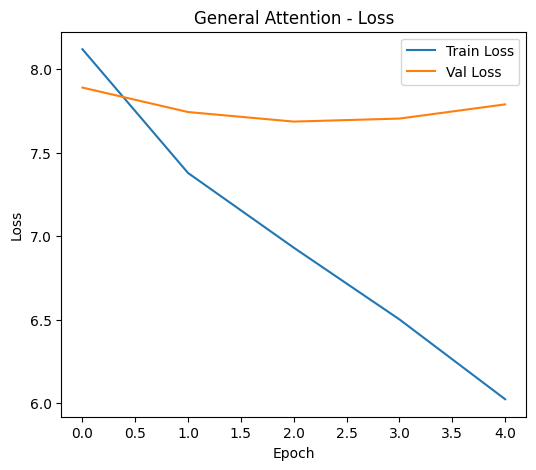

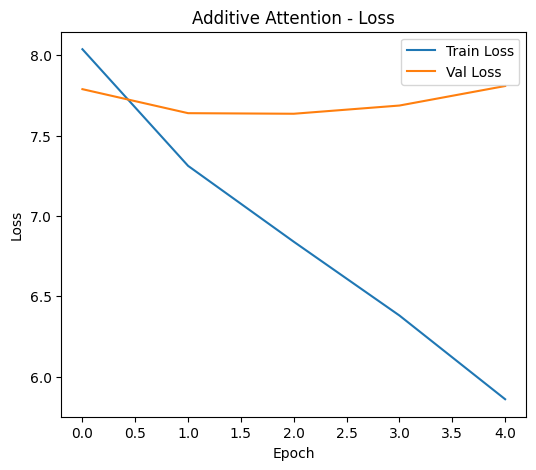

In [18]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(6, 5))
    
    # Plot Loss
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['valid_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Visualize both models
plot_history(history_general, "General Attention")
plot_history(history_additive, "Additive Attention")


## Translation Function (Inference)
Since our training loop used "Teacher Forcing" (feeding the correct answer), inference requires a different loop called Greedy Decoding. We feed the predicted word from step $t$ as the input for step $t+1$.This function also captures the attention weights at every step so we can visualize them later.

In [19]:
import sys
!{sys.executable} -m pip install seaborn



[notice] A new release of pip is available: 23.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
import seaborn as sns

def translate_sentence(sentence, src_vocab, trg_vocab, model, device, max_len=50):
    model.eval()
    
    # 1. Numericalize the input sentence
    tokens = numericalize(sentence.lower(), src_vocab)
    src_tensor = torch.LongTensor(tokens).unsqueeze(0).to(device) # [1, src_len]
    
    with torch.no_grad():
        # 2. Encode
        encoder_outputs, hidden = model.encoder(src_tensor)
        
        # 3. Decode loop
        trg_indices = [trg_vocab.word2idx['<sos>']]
        attention_matrix = []
        
        for _ in range(max_len):
            trg_tensor = torch.LongTensor([trg_indices[-1]]).to(device)
            
            # Forward pass through decoder
            prediction, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs)
            
            # Save attention weights (remove batch dim) -> [1, src_len]
            attention_matrix.append(attention.squeeze(0).cpu().numpy())
            
            # Get highest probability word index
            pred_token = prediction.argmax(1).item()
            trg_indices.append(pred_token)
            
            if pred_token == trg_vocab.word2idx['<eos>']:
                break
    
    # 4. Convert indices back to words
    trg_words = [trg_vocab.idx2word[i] for i in trg_indices]
    
    # Remove <sos> from start
    return trg_words[1:], attention_matrix

## Visualizing Attention Maps
This function takes the raw attention matrix captured during translation and plots it as a heatmap. This allows us to interpret why the model chose specific words.

General Model Translation: म म म <eos>


c:\NLP_notebook\A3\nlp_env\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\NLP_notebook\A3\nlp_env\lib\site-packages\seaborn\utils.py:61: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
c:\NLP_notebook\A3\nlp_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\NLP_notebook\A3\nlp_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)


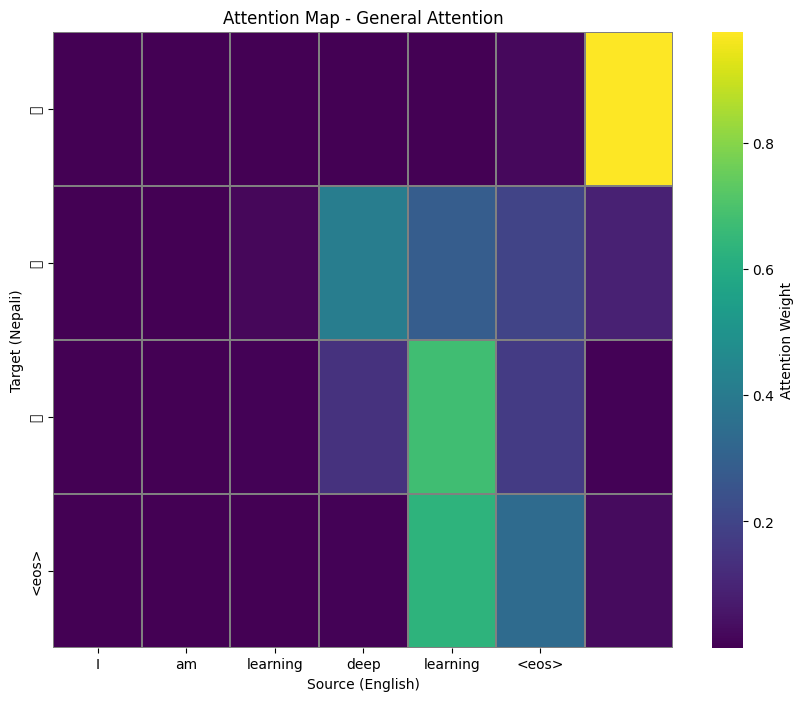

Additive Model Translation: म म म म म म म <eos>


c:\NLP_notebook\A3\nlp_env\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\NLP_notebook\A3\nlp_env\lib\site-packages\seaborn\utils.py:61: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
c:\NLP_notebook\A3\nlp_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\NLP_notebook\A3\nlp_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)


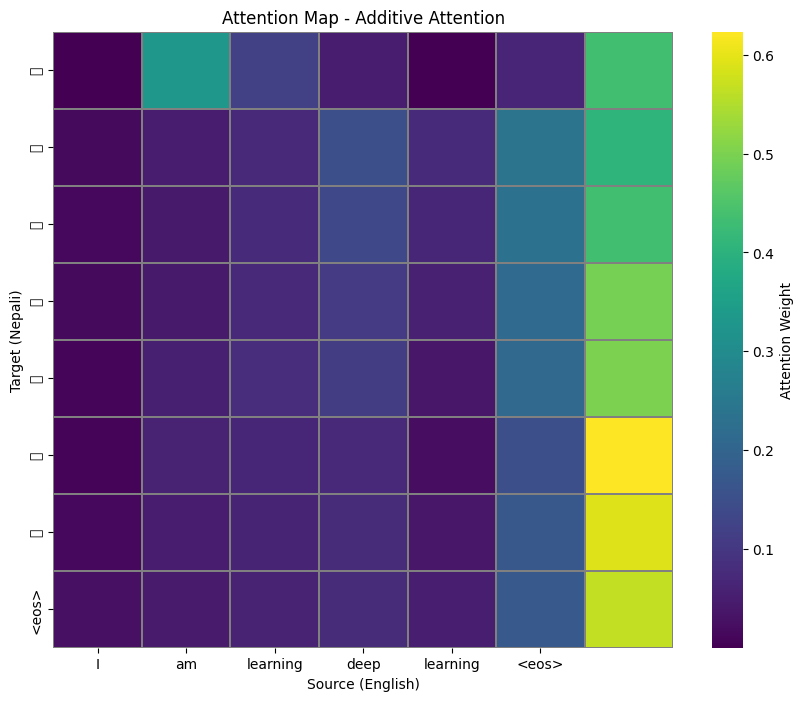

In [ ]:
import numpy as np

def display_attention(sentence, translation, attention, model_name="Model"):
    # Convert attention list to 2D numpy array
    # Shape: [trg_len, src_len]
    attention_map = np.concatenate(attention, axis=0)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create Heatmap
    sns.heatmap(attention_map, 
                xticklabels=sentence.split() + ['<eos>'], 
                yticklabels=translation, 
                cmap='viridis', 
                annot=False,
                linewidths=0.1,
                linecolor='gray',
                cbar_kws={'label': 'Attention Weight'})
    
    ax.set_xlabel('Source (English)')
    ax.set_ylabel('Target (Nepali)')
    ax.set_title(f'Attention Map - {model_name}')
    plt.show()


# Pick a sentence from the test set or write a new one
sample_text = "I am learning deep learning"

# 1. Translate with General Attention
trans_gen, attn_gen = translate_sentence(sample_text, eng_vocab, nep_vocab, model_general, device)
print(f"General Model Translation: {' '.join(trans_gen)}")
display_attention(sample_text, trans_gen, attn_gen, "General Attention")

# 2. Translate with Additive Attention
trans_add, attn_add = translate_sentence(sample_text, eng_vocab, nep_vocab, model_additive, device)
print(f"Additive Model Translation: {' '.join(trans_add)}")
display_attention(sample_text, trans_add, attn_add, "Additive Attention")

In [22]:
import pickle

# 1. Save the best model (Additive Attention)
torch.save(model_additive.state_dict(), 'Additive_Attention-model.pt')

# 2. Save the vocabularies
with open('src_vocab.pkl', 'wb') as f:
    pickle.dump(eng_vocab, f)
with open('trg_vocab.pkl', 'wb') as f:
    pickle.dump(nep_vocab, f)

print("Files saved: 'Additive_Attention-model.pt', 'src_vocab.pkl', 'trg_vocab.pkl'")

Files saved: 'Additive_Attention-model.pt', 'src_vocab.pkl', 'trg_vocab.pkl'
